In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import os
import warnings
import h5py
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import windOF as foam
import windPlotting as wPlt
import wind

import winsound

In [5]:
def convertDFSR_out_toNPY(inflDir, sampleName, overwrite=False):
    file_time = inflDir+sampleName+'/time.npy'
    file_probes = inflDir+sampleName+'/probes.npy'
    file_UofT = inflDir+sampleName+'/UofT.npy'
    file_VofT = inflDir+sampleName+'/VofT.npy'
    file_WofT = inflDir+sampleName+'/WofT.npy'
    allFilesExist = os.path.isfile(file_time) and os.path.isfile(file_probes) and os.path.isfile(file_UofT) and os.path.isfile(file_VofT) and os.path.isfile(file_WofT)
    print(f'Case: {sampleName} ...\n')
    if allFilesExist and not overwrite:
        print(f'\tAll files exist. Skipping conversion from DFSR samples to NPY files.')
        return
    
    probes, time, UofT = foam.read_OF_probe_single(inflDir+sampleName+'/Ux','p')
    print('\tFinished reading UofT')
    _, _, VofT = foam.read_OF_probe_single(inflDir+sampleName+'/Uy','p')
    print('\tFinished reading VofT')
    _, _, WofT = foam.read_OF_probe_single(inflDir+sampleName+'/Uz','p')
    print('\tFinished reading WofT')

    UofT = np.transpose(UofT)
    VofT = np.transpose(VofT)
    WofT = np.transpose(WofT)
    print(f"Shapes: \tUofT: {UofT.shape}, \tVofT: {VofT.shape}, \tWofT: {WofT.shape}")

    if UofT.shape[-1] != VofT.shape[-1] or UofT.shape[-1] != WofT.shape[-1]:
        print('Shapes of UofT, VofT, WofT are not the same. Trimming the longer ones.')
        minLen = np.min([UofT.shape[-1], VofT.shape[-1], WofT.shape[-1]])
        UofT = UofT[:,:minLen]
        VofT = VofT[:,:minLen]
        WofT = WofT[:,:minLen]

    np.save(file_time,time)
    np.save(file_probes,probes)
    np.save(file_UofT,UofT)
    np.save(file_VofT,VofT)
    np.save(file_WofT,WofT)

    winsound.Beep(1000, 1000)

def saveFoamCaseTH_toFile(caseDir, probeName, H,):
    les_x0 = foam.processVelProfile(caseDir,probeName=probeName,name="___",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H, showLog=False)
    np.save(caseDir+probeName+'_time.npy',les_x0.t)
    np.save(caseDir+probeName+'_Z.npy',les_x0.Z)
    np.save(caseDir+probeName+'_UofT.npy',les_x0.UofT)
    np.save(caseDir+probeName+'_VofT.npy',les_x0.VofT)
    np.save(caseDir+probeName+'_WofT.npy',les_x0.WofT)



In [6]:
raw_wtFile_fine = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Fr1_forPython.mat"
raw_wtFile_med2 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr2_forPython.mat"
raw_wtFile_med3 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr3_forPython.mat"
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"

inflowDir_E2 = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

lScl=0.02
H = 0.08


# Load the target wind field

The current profile data has already been scaled in Matlab. The cobra probe $U_h$ was around 7 $m/s$.

In [7]:
Uh_HFPI = 12.5
Uh_cobra = 7.6
vel_ratio = Uh_HFPI/Uh_cobra

data = h5py.File(raw_wtFile_fine, 'r')
print(data.keys())
Z = data['Z'][0]
U_TH = np.array(data['UofT']).copy()*vel_ratio
V_TH = np.array(data['VofT']).copy()*vel_ratio
W_TH = np.array(data['WofT']).copy()*vel_ratio
dt = data['dt'][0][0]/vel_ratio
wtVel_E2 = wind.profile(name="BLWT-E2 (F)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32)
del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med2, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M2 = wind.profile(name="BLWT-E2 (M2)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med3, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M3 = wind.profile(name="BLWT-E2 (M3)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))

wt_vs_ESDU = wind.Profiles([wtVel_E2, esdu74_E2.toProfileObj(n=np.logspace(-2.5,1.5,100)), esdu85_E2.toProfileObj(n=np.logspace(-2.5,1.5,100))],)


<KeysViewHDF5 ['H', 'README', 'UofT', 'VofT', 'WofT', 'Z', 'dt', 'exposureName']>


## Trial 1
- Basic trial
- Scaling is applied based on ratio over the entire profile

In [28]:
infl_E2_trial1 = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r2')
infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r2', name='DFSR.r2')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r2.s2')
infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r2.s2', name='DFSR.r2.s2')

# infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v0/', probeName='prof_x0_y0', name='tngE2.ed.v0', readFromNPY_file=True, writeToDataFile=True)
infl_E2_trial1.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v1/', probeName='prof_x0_y0', name='tngE2.ed.v1', readFromNPY_file=True, writeToDataFile=True)
infl_E2_trial1.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v1.m2/', probeName='prof_x0_y0', name='tngE2.ed.v1.m2', readFromNPY_file=True, writeToDataFile=True)
# infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v2/', probeName='prof_x0_y0', name='tngE2.ed.v2', readFromNPY_file=True, writeToDataFile=True)


n=np.logspace(-3.5,1.5,100)
infl_E2_trial1.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), wind.ESDU85(z0=0.02).toProfileObj(n=n), ])

Case: infl.r0
	All files exist. Skipping conversion from DFSR samples to NPY files.
Case: infl.r1
	All files exist. Skipping conversion from DFSR samples to NPY files.
Case: infl.r2
	All files exist. Skipping conversion from DFSR samples to NPY files.
Case: infl.r2.s2
	All files exist. Skipping conversion from DFSR samples to NPY files.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v1/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v1//postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v1.m2/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v1.m2//postProcessi

## Trial 2
Changes:
- Fixed the scaling ratio to a fixed value corresponding to the reference height for the second round. 


In [15]:
infl_E2_trial2 = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v1')
infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v1', name='DFSR.fr.r1 (bad_W)')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v2')
infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v2', name='DFSR.fr.r2')

convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v3')
infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v3', name='DFSR.fr.r3')

infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v0/', probeName='prof_x0_y0', name='tngE2.ed.v0', readFromNPY_file=True, writeToDataFile=True,
                       kwargs_profile={'nSpectAvg':32})
infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v1.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v1.m2', readFromNPY_file=True, writeToDataFile=True,
                       kwargs_profile={'nSpectAvg':32})
infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v2.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v2.m2', readFromNPY_file=True, writeToDataFile=True, 
                       kwargs_profile={'nSpectAvg':32})
infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v3.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v3.m2', readFromNPY_file=False, writeToDataFile=True)


n=np.logspace(-3.5,2.5,100)
infl_E2_trial2.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), wind.ESDU85(z0=0.02).toProfileObj(n=n), ])

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0//postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.fr.v1.m2/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.fr.v1.m2//postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED

### Trial 2: scale & export

Scaling round: 0
    Scaling type			: Fixed roof-height ratio.
    Input 				: BLWT-E2 (F)
    Output 				: tngE2.ed.v0
    Latest roof height ratio 		: U = 1.000, Iu = 1.000, Iv = 1.000, Iw = 1.000, xLu = 1.000, xLv = 1.000, xLw = 1.000
    Cumulative roof height ratio 	: U = 1.624, Iu = 0.999, Iv = 1.255, Iw = 1.184, xLu = 1.628, xLv = 2.298, xLw = 1.353

Scaling round: 1
    Scaling type			: Full-profile ratio.
    Input 				: tngE2.ed.v0 (scaled)
    Output 				: tngE2.ed.fr.v1.m2
    Latest roof height ratio 		: U = 1.624, Iu = 0.999, Iv = 1.255, Iw = 1.184, xLu = 1.628, xLv = 2.298, xLw = 1.353
    Cumulative roof height ratio 	: U = 1.786, Iu = 0.796, Iv = 1.603, Iw = 1.206, xLu = 1.628, xLv = 2.298, xLw = 1.353

Scaling round: 2
    Scaling type			: Fixed roof-height ratio.
    Input 				: tngE2.ed.v0 (scaled)
    Output 				: tngE2.ed.fr.v2.m2
    Latest roof height ratio 		: U = 1.786, Iu = 0.796, Iv = 1.603, Iw = 1.206, xLu = 1.628, xLv = 2.298, xLw = 1.353
    Cumulative ro

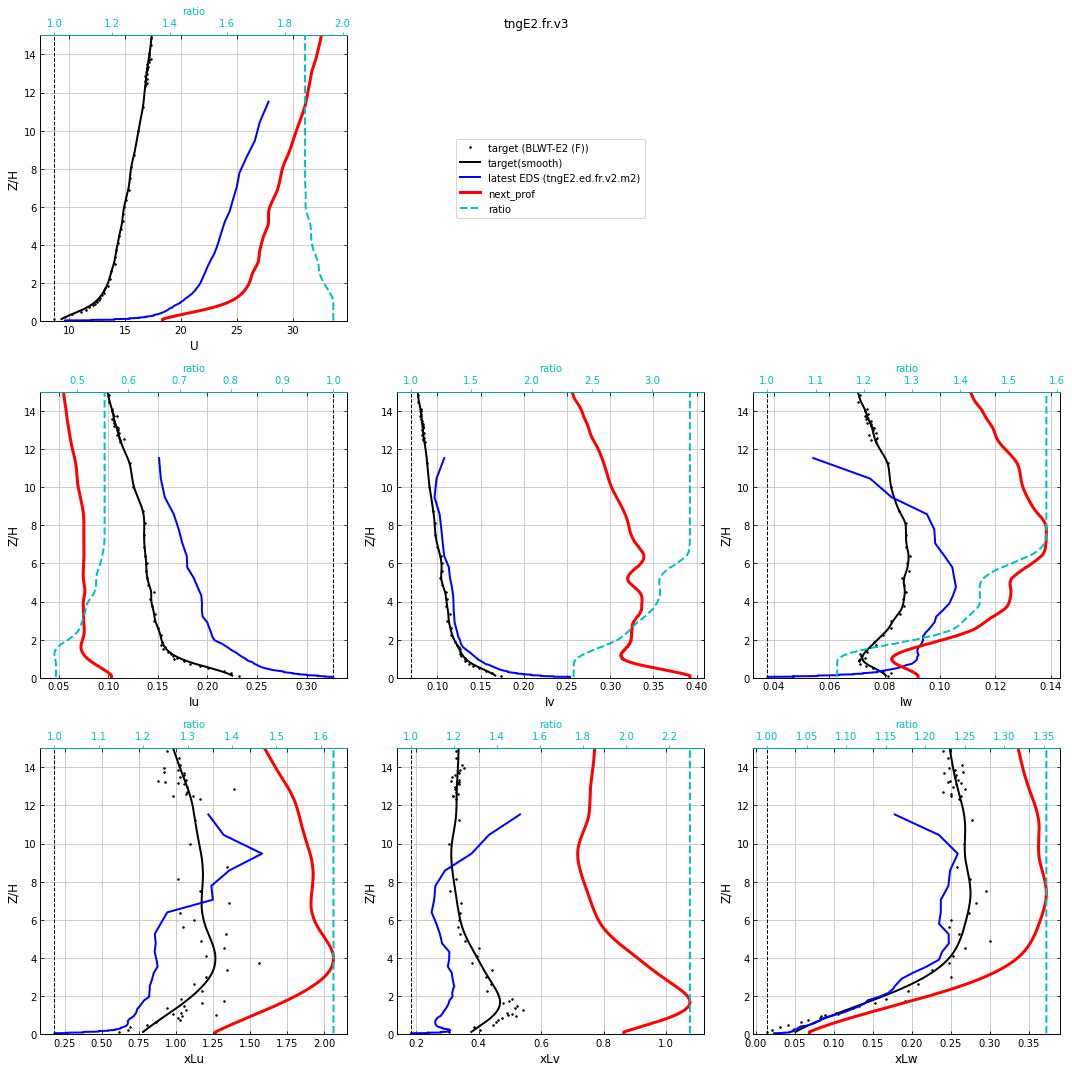

In [41]:
rnd = 3
caseName = f'tngE2.fr.v{rnd}'
prof = infl_E2_trial2.writeProfile(
                            # dir=inflowDir_E2 + f'tuning/infl.r{rnd}/', 
                            # dir=inflowDir_E2 + f'tuning/{caseName}/', 
                            caseName=caseName,
                            rounds=rnd,
                            zLim=[0,15],
                            debugMode=True,
                            applySmoothing=True,
                            applyLimitedSmoothing=False,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.08,
                            zMax_scaling=0.08*7,
                                          # round:      [0,     1,      2,      3,      4, 5, 6]
                            scaleByFixedRefHeightRatio= [True,  False,  True,   True,],
                            scale_xLi=                  [True,  False,  False,  False,],
                            smoothWindow=[50, 50, 50, 50, 200, 150, 200],
                            figsize=[15,15])


## Trial 3
Changes:
- Quick test comparison between the baseline `infl.r0` and `infl.r0.n25m4096` showed that increasing `nFreq` improved the integral length scale. 
- It also had an impact on the turbulence intensity and spectra.
- The effect of `nInterp` was also tested, but it didn't have as much impact.
- In these sets, `nFreq` is increased from 1024 to 4096 and `nInterp` is kept as the default 25.
- This lets us avoid the need to scale the integral length scale.


In [91]:
infl_E2_trial3 = foam.inflowTuner(H=H, nSpectAvg=16, target=wtVel_E2,)

trial_dir_in = inflowDir_E2+'tuning.trial3/'

name = 'infl.t3.r0'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name)

name = 'infl.t3.r1'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name)


trial_dir_ed = inflowDir_E2+'ED.trial3/'

name = 'tngE2.ed.t3.r0'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':8})

name = 'tngE2.ed.t3.r1'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=False, writeToDataFile=True, kwargs_profile={'nSpectAvg':8})


n=np.logspace(-3.5,2.5,100)

vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E2.SpectH
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

infl_E2_trial3.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), wind.ESDU85(z0=0.01).toProfileObj(n=n), vonk])
# infl_E2_trial3.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), ])

Case: infl.t3.r0
	All files exist. Skipping conversion from DFSR samples to NPY files.
Case: infl.t3.r1
	All files exist. Skipping conversion from DFSR samples to NPY files.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r0/postProcessing/prof_x0_y0
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r0/postProcessing/prof_x0_y0/0/U
                61 probes with 6713 time steps (0.0 to 13.424)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (6713, 61, 3)
           Reading U from: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r0/postProcessing/prof_x0_y0/13.25/U
                61 probes with 7157 time steps (13.25 to 27.562)
                No. of ove

### Trial 3: scale & export

Scaling round: 0
    Scaling type			: Full-profile ratio.
    Input 				: BLWT-E2 (F)
    Latest ED LES 			: tngE2.ed.t3.r0
    Latest roof height ratio 		: U = 1.000, Iu = 1.000, Iv = 1.000, Iw = 1.000, xLu = 1.000, xLv = 1.000, xLw = 1.000
    Cumulative roof height ratio 	: U = 1.022, Iu = 0.858, Iv = 1.269, Iw = 1.157, xLu = 1.000, xLv = 1.000, xLw = 1.000

Scaling round: 1
    Scaling type			: Fixed roof-height ratio.
    Input 				: tngE2.ed.t3.r0 (scaled)
    Latest ED LES 			: tngE2.ed.t3.r1
    Latest roof height ratio 		: U = 1.022, Iu = 0.858, Iv = 1.269, Iw = 1.157, xLu = 1.000, xLv = 1.000, xLw = 1.000
    Cumulative roof height ratio 	: U = 1.023, Iu = 0.616, Iv = 1.731, Iw = 1.343, xLu = 1.000, xLv = 1.000, xLw = 1.000



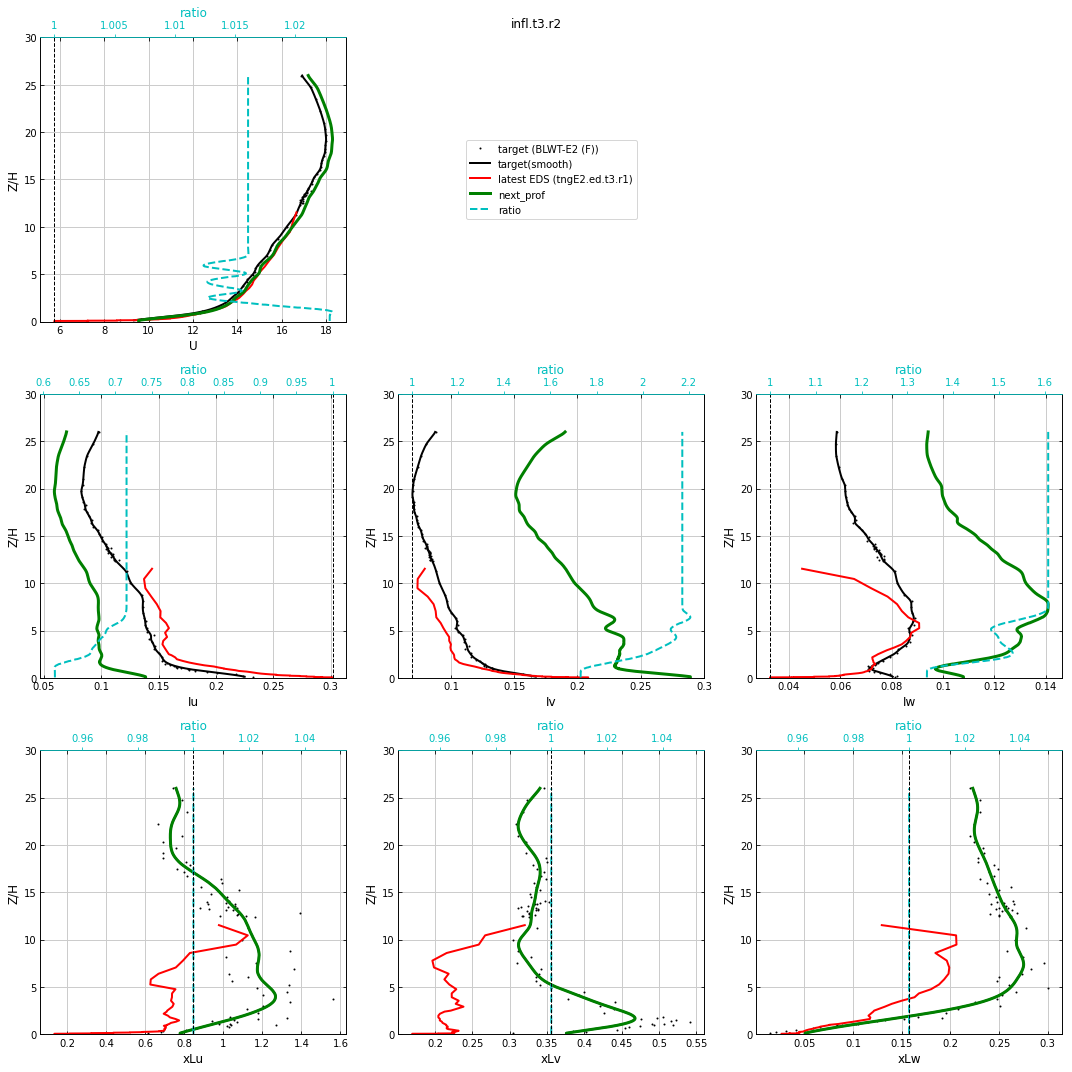

In [99]:
rnd = 2
caseName = f'infl.t3.r{rnd}'
prof = infl_E2_trial3.writeProfile(
                            # dir=trial_dir_in + f'/{caseName}/',
                            caseName=caseName,
                            # description='Round 0: Original target (round 0) with increased nFreq = 8192 (verify this from DFSR log). That should avoid the need for scaling the integral length scale. The Iu is expected to be higher than the target which will be scaled down in the next round.',
                            # description='Round 1: First round with increased nFreq = 8192 (verify this from DFSR log). Scaled by variable ratio along the profile.',
                            description='Round 2: Second round with increased nFreq = 8192 (verify this from DFSR log). Scaled by fixed ratio along the profile.',
                            rounds=rnd,
                            zLim=[0,30],
                            debugMode=True,
                            applySmoothing=True,
                            applyLimitedSmoothing=False,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.08,
                            zMax_scaling=0.08*7,
                                            # round:    [1,      2,      3,      4, 5, 6]
                            scaleByFixedRefHeightRatio= [False,  True,],
                            scale_xLi=                  [False,  False,],
                            smoothWindow=[50, 50, 50, 50, 200, 150, 200],
                            figsize=[15,15])


# Plot a trial set

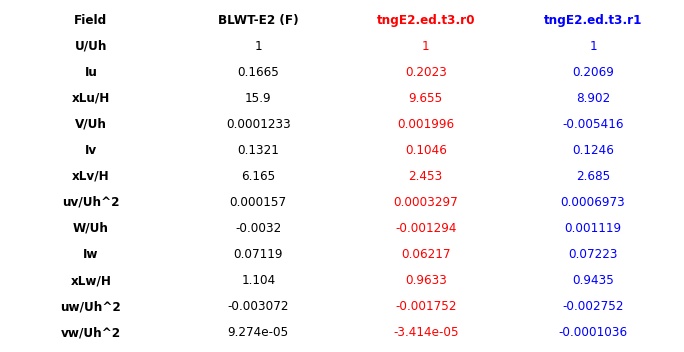

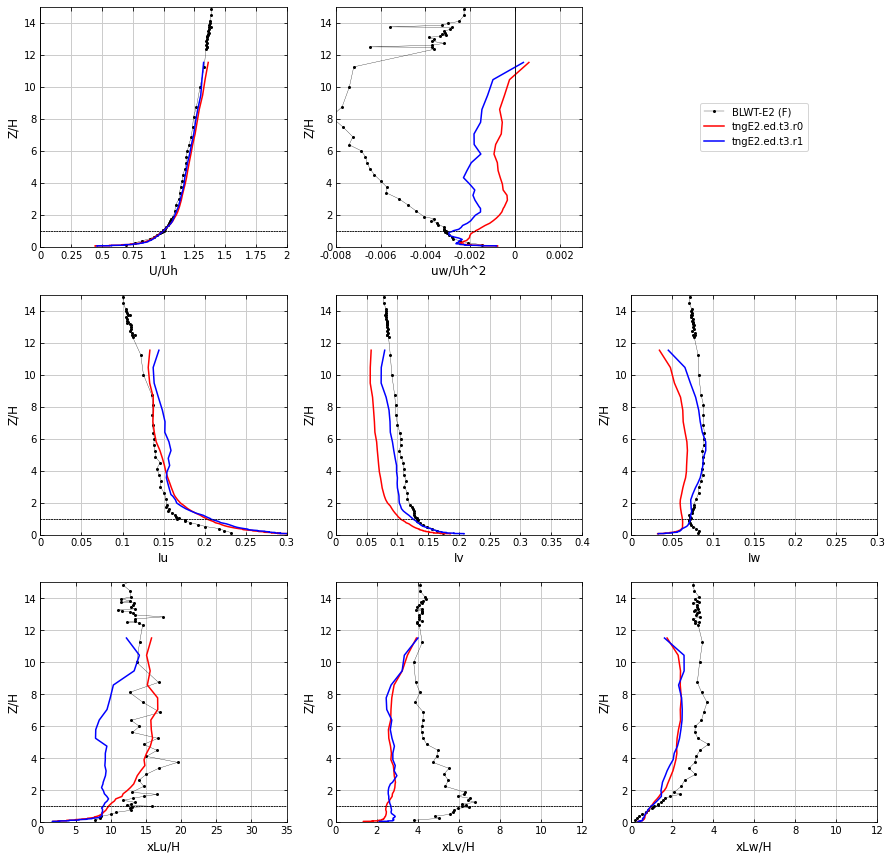

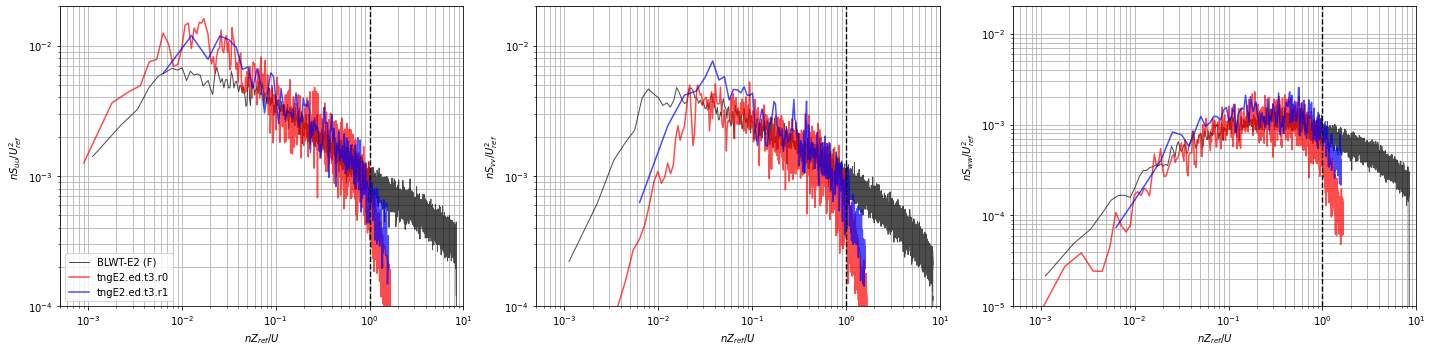

In [95]:
(fig,_), (table,_) = infl_E2_trial3.plotProfiles(figsize=[15,15], 
                        zLim=[0,15], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
                        includeInflows=False, includeIncidents=True, includeRefProfiles=False,
                        normalize=True,
                        ms=4, lw=1.5,
                        )
# fig.savefig(trial_dir_ed+'/profiles.svg', dpi=300, bbox_inches='tight')
# table.savefig(trial_dir_ed+'/profiles_table.svg', dpi=300, bbox_inches='tight')

fig = infl_E2_trial3.plotSpectra(figSize=[20,5],
                    includeInflows=False, includeIncidents=True, includeRefProfiles=False, 
                    yLimits=[[1e-4,0.02],[1e-4,0.02],[1e-5,0.02]],
                    xLimits=[5e-4,1e1],
                    )
# fig.savefig(trial_dir_ed+'/spectra.svg', dpi=300, bbox_inches='tight')


In [100]:
print(infl_E2_trial3.inflows[0].T)

59.998400000000004


# Quick tests

In [8]:
inflowDir_E2_test = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

infl_quick = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed1')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed1', name='DFSR.r0.seed1')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed2')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed2', name='DFSR.r0.seed2')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed3')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed3', name='DFSR.r0.seed3')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')


# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0.n200')
# infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0.n200', name='DFSR.r0.n200')


# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0.n25m4096')
infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0.n25m4096', name='DFSR.r0.n25m4096')

n=np.logspace(-3.5,2.5,100)
infl_quick.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), ])

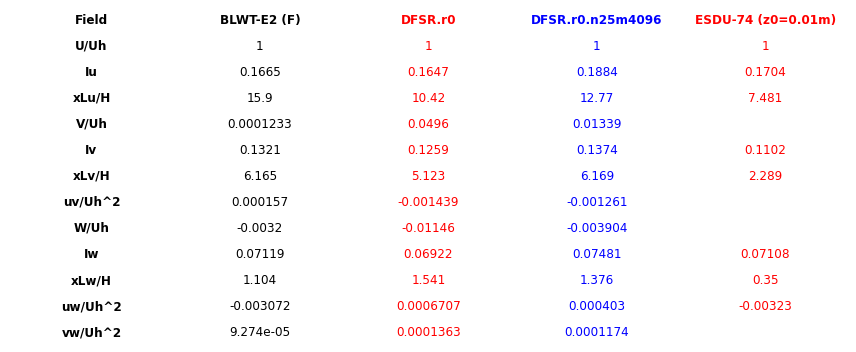

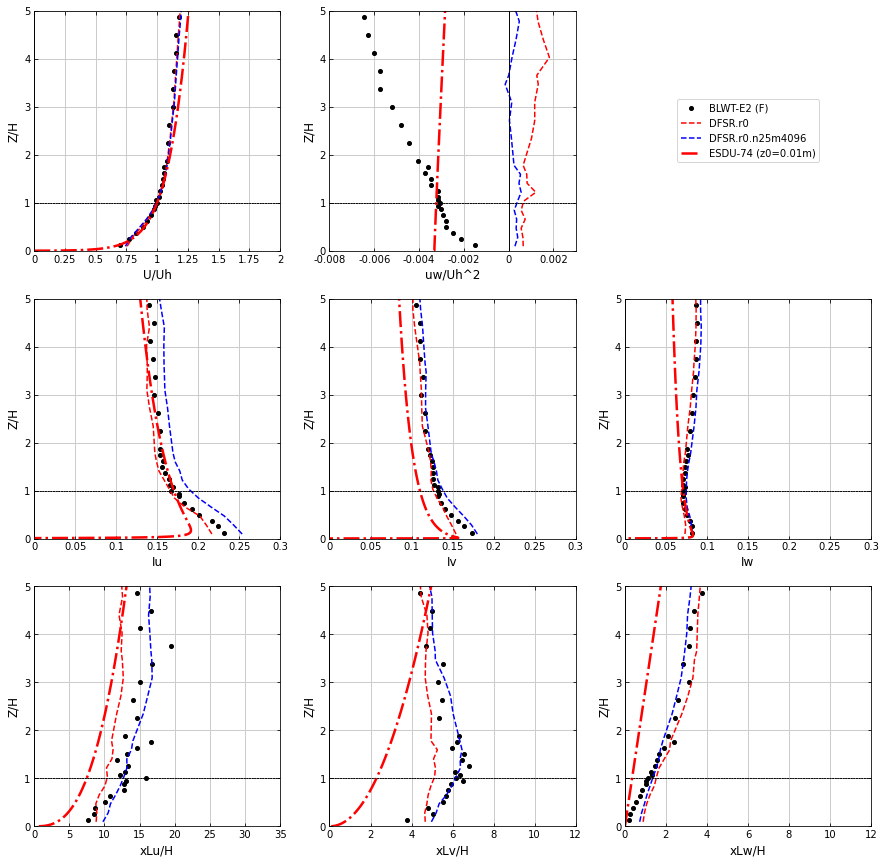

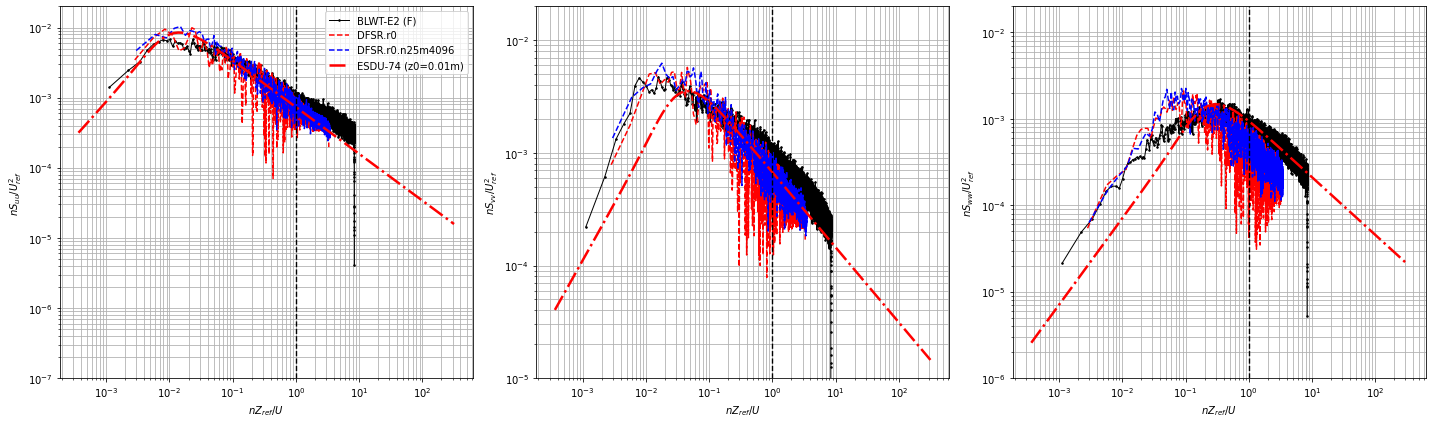

In [9]:
infl_quick.plotProfiles(figsize=[15,15], 
                        zLim=[0,5], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
                        includeInflows=True, includeIncidents=False, normalize=True,
                        ms=4, lw=1.5)
infl_quick.plotSpectra(figSize=[20,6],
                    includeInflows=True, includeIncidents=False,
                    yLimits=[[1e-7,2e-2],[1e-5,2e-2],[1e-6,2e-2]],)

Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_inf/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.495/U
                61 probes with 1032 time steps (0.495 to 0.7012)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (1032, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.7/U
                61 probes with 1405 time steps (0.7 to 0.9808)
                No. of overlapping time steps with previously read data: 7
                Shape of data: (1405, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.98/U
                61 probes with 1391 time steps (0.98 to 1.258)
                No. of overlapping t

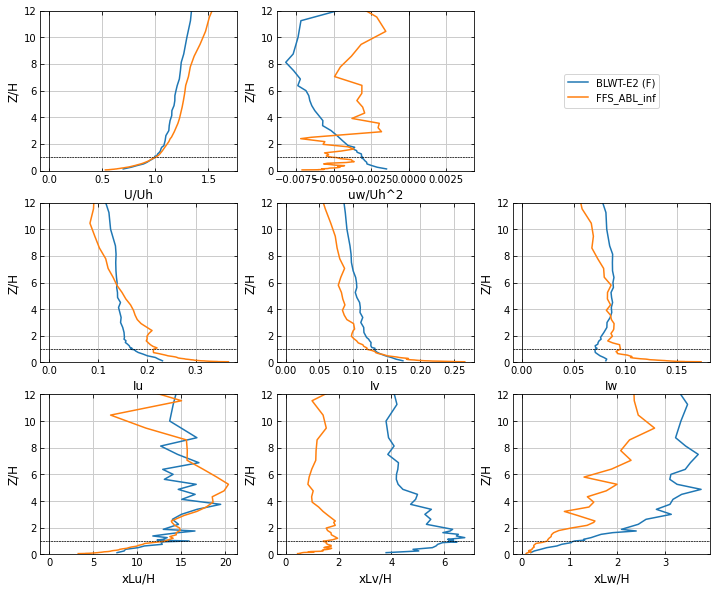

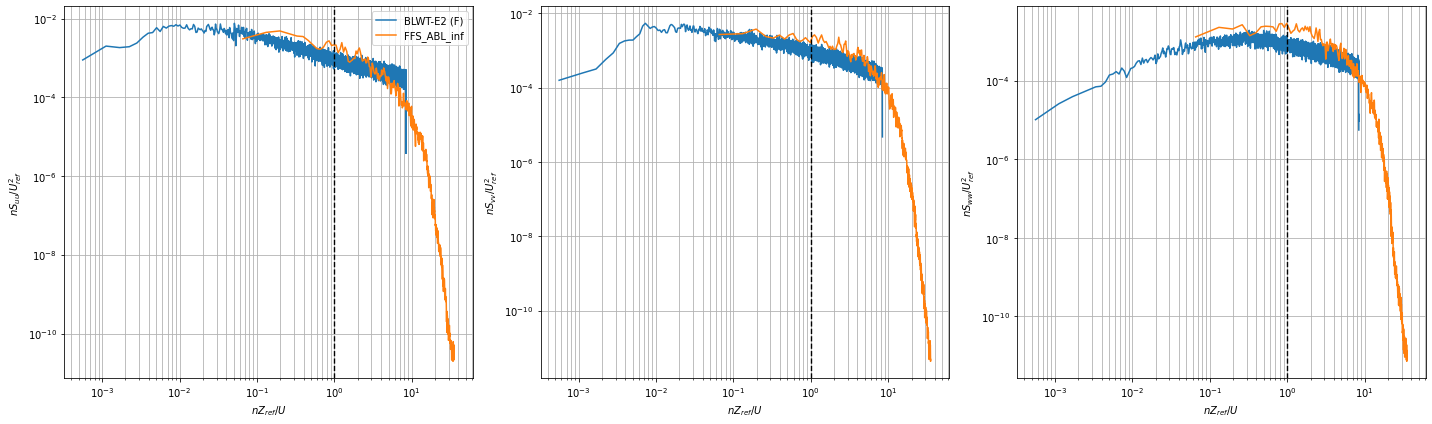

In [106]:
prof = foam.readVelProfile(caseDir=r'D:/tempData_depot/simData_FFS/FFS_ABL_inf/',
                           probeName=r'probes.zProfile.x0.0',
                           name='FFS_ABL_inf', 
                           showLog=True, 
                           trimTimeSegs=[[0,0.1],],
                           H=0.08)
profs = wind.Profiles([wtVel_E2, prof,])
profs.plotProfile_basic2(yLimits=[0,12])
profs.plotSpectra(figSize=[20,6],)